#### Skip-Gram: Try learn embeddings of users similar to posts

In [131]:
import torch
import random

In [34]:
corpus = [
    "the quick brown fox jumps over the lazy dog",
    "we love natural language processing",
    "embedding learning is fun and useful",
    "skip gram model learns word representations",
    "deep learning helps in many nlp tasks"
]

In [52]:
class Preprocessor():
  def __init__(self, corpus):
    self.corpus = corpus
  def tokenize(self):
    self.vocab = {}
    for sentence in self.corpus:
      for word in sentence.split():
        if word not in self.vocab:
          self.vocab[word.lower()] = len(self.vocab)
  def update_corpus(self):
    if not self.vocab:
      raise ValueError("No vocabulary initialized. "
                       "Please run processor.tokenize()")
    self.transformed_corpus = [[self.vocab[word.lower()]
             for word in sentence.split()]
             for sentence in corpus]
  def generate_pairs(self, window_size: int):
    """
    window size is the number of words on either side of the center word
    """
    if not self.transformed_corpus:
      raise ValueError("No transformed corpus created.")
    self.train_data = []
    full_width = 2*window_size+1
    # when generating pairs, context window can be variable
    # so make pairs (center, context)
    for word_lst in self.transformed_corpus:
      if len(word_lst) < full_width:
        continue
      for idx in range(len(word_lst)):
        # (center_word, context words)
        # clamp words from start or end
        left = max(0, idx-window_size)
        right = min(len(word_lst), idx+window_size)
        for context in word_lst[left:idx]+word_lst[(idx+1):(right+1)]:
          self.train_data.append((word_lst[idx], context))


In [53]:
processor = Preprocessor(corpus=corpus)
processor.tokenize()
processor.update_corpus()
processor.generate_pairs(window_size=2)
processor.train_data

[(0, 1),
 (0, 2),
 (1, 0),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 4),
 (3, 1),
 (3, 2),
 (3, 4),
 (3, 5),
 (4, 2),
 (4, 3),
 (4, 5),
 (4, 0),
 (5, 3),
 (5, 4),
 (5, 0),
 (5, 6),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (6, 5),
 (6, 0),
 (6, 7),
 (7, 0),
 (7, 6),
 (8, 9),
 (8, 10),
 (9, 8),
 (9, 10),
 (9, 11),
 (10, 8),
 (10, 9),
 (10, 11),
 (10, 12),
 (11, 9),
 (11, 10),
 (11, 12),
 (12, 10),
 (12, 11),
 (13, 14),
 (13, 15),
 (14, 13),
 (14, 15),
 (14, 16),
 (15, 13),
 (15, 14),
 (15, 16),
 (15, 17),
 (16, 14),
 (16, 15),
 (16, 17),
 (16, 18),
 (17, 15),
 (17, 16),
 (17, 18),
 (18, 16),
 (18, 17),
 (19, 20),
 (19, 21),
 (20, 19),
 (20, 21),
 (20, 22),
 (21, 19),
 (21, 20),
 (21, 22),
 (21, 23),
 (22, 20),
 (22, 21),
 (22, 23),
 (22, 24),
 (23, 21),
 (23, 22),
 (23, 24),
 (24, 22),
 (24, 23),
 (25, 14),
 (25, 26),
 (14, 25),
 (14, 26),
 (14, 27),
 (26, 25),
 (26, 14),
 (26, 27),
 (26, 28),
 (27, 14),
 (27, 26),
 (27, 28),
 (27, 29),
 (28, 26),
 (28, 27),
 (28, 29),
 (28, 30),
 (2

In [97]:
class SkipGram(torch.nn.Module):
  def __init__(self, vocab_size, emb_dim):
    super(SkipGram, self).__init__()
    self.emb_layer = torch.nn.Embedding(vocab_size, emb_dim)
    self.output_layer = torch.nn.Linear(emb_dim, vocab_size, bias=True)
  def forward(self, x):
    x = self.emb_layer(x)
    return self.output_layer(x)

In [132]:
def train(epochs: int,
          batch_size: int,
          learning_rate: float,
          processor: Preprocessor):
    emb_model = SkipGram(vocab_size=len(processor.vocab),
                         emb_dim=32)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(params=emb_model.parameters(),lr=learning_rate)
    for epoch in range(epochs):
      total_loss = 0
      random.shuffle(processor.train_data)
      batches = [(torch.Tensor([v[0] for v in processor.train_data[i:(i+batch_size)]]),\
                torch.Tensor([v[1] for v in processor.train_data[i:(i+batch_size)] ] ) )
                for i in range(0, len(processor.train_data), batch_size)]
      for (centers, contexts) in batches:
        centers = centers.long()
        contexts = contexts.long()
        preds = emb_model(centers)
        loss = loss_fn(preds, contexts)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      print(f"Epoch {epoch+1} | Loss: {total_loss / len(batches)}")

    return emb_model.emb_layer


In [147]:
emb_layer = train(epochs=15,
      batch_size=15,
      learning_rate=0.01,
      processor=processor)

Epoch 1 | Loss: 3.5948919568743025
Epoch 2 | Loss: 3.1123418467385426
Epoch 3 | Loss: 2.768576213291713
Epoch 4 | Loss: 2.4962713718414307
Epoch 5 | Loss: 2.267376491001674
Epoch 6 | Loss: 2.0806084871292114
Epoch 7 | Loss: 1.9272256919315882
Epoch 8 | Loss: 1.7934833935328893
Epoch 9 | Loss: 1.6854295560291834
Epoch 10 | Loss: 1.6103176730019706
Epoch 11 | Loss: 1.5577298062188285
Epoch 12 | Loss: 1.5059640407562256
Epoch 13 | Loss: 1.4807374307087489
Epoch 14 | Loss: 1.4563910620553153
Epoch 15 | Loss: 1.4398809501102992


In [148]:
emb_layer.weight

Parameter containing:
tensor([[ 5.8624e-01,  2.6610e-01,  1.6578e-01,  1.1418e+00, -3.6867e-01,
         -1.8198e+00,  1.5329e+00,  4.1362e-02,  7.7059e-01, -5.3985e-01,
         -1.3177e+00,  1.9100e+00, -3.9919e-01, -2.1123e+00, -7.0777e-01,
         -2.1325e+00, -3.9566e-01, -7.5621e-01,  5.8381e-01, -1.1780e+00,
          1.9360e+00,  8.6959e-01, -1.4455e+00, -4.6521e-01,  5.2020e-01,
         -1.2329e+00,  1.6408e+00, -8.2254e-01,  7.4606e-01,  1.0616e-01,
         -1.3648e+00,  8.5626e-01],
        [ 9.4476e-01,  1.5659e+00, -8.2011e-01, -6.2384e-01,  7.0940e-01,
         -2.6127e-01,  1.2483e-01, -1.2232e+00, -9.5858e-01,  5.9168e-01,
         -8.6497e-01, -5.5044e-01,  8.0775e-01,  3.1187e-01, -1.3476e+00,
         -9.3461e-01,  9.4754e-01,  2.0979e+00, -1.1004e+00, -2.0714e+00,
         -9.1398e-01, -1.0582e+00,  1.0147e+00,  1.1596e+00,  1.2760e+00,
          6.1389e-01, -9.0033e-01, -7.2338e-01, -2.0433e+00, -1.1204e+00,
         -1.0578e+00,  9.9715e-01],
        [-1.3059e-

* Note splitting up pairs of center, context given variable context windows
per sentence in the corpus
* nn.Embedding instead of nn.Linear as the former is an efficient id lookup that can be batched without extra plumbing.
* torch.nn.CrossEntropyLoss uses logits, not probabilities
* ensure the ids are long types.

In [149]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_embeddings(embedding_layer, processor, method='pca'):
    weights = embedding_layer.weight.data.cpu().numpy()

    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("method should be 'pca' or 'tsne'")

    reduced_embeds = reducer.fit_transform(weights)

    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeds[:, 0], reduced_embeds[:, 1])

    # Annotate points with word labels
    idx_to_word = {idx: word for word, idx in processor.vocab.items()}
    for i, (x, y) in enumerate(reduced_embeds):
        plt.text(x+0.01, y+0.01, idx_to_word[i], fontsize=9)

    plt.title(f'Word Embeddings Visualization ({method.upper()})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()


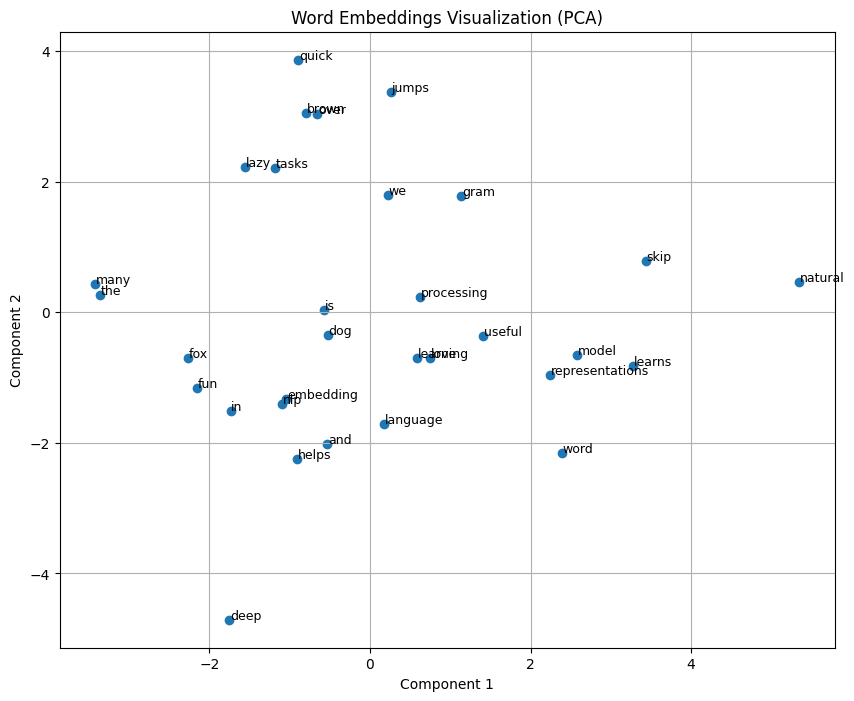

In [150]:
visualize_embeddings(emb_layer, processor)